## LL

In [96]:
import json
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd    
import xarray as xr

In [97]:
save_dir = '/home/hanna/MS-suppl/files/'
sat_dir = '/home/hanna/lagrings/satelite_coordinates/msthesis/'

ex_fil = glob.glob(save_dir + '*ERA5*.json')[0]
with open(ex_fil, 'r') as f:
    data_grid = json.load(f)

In [98]:
satfil = glob.glob(sat_dir + '*nc')[-1]

In [99]:
satfil

'/home/hanna/lagrings/satelite_coordinates/msthesis/cloud_mask.nc'

In [100]:
def read_dlon_dlat(save_dir):
    nc_files = glob.glob(save_dir+'*cell*.json')
    #print(nc_files)
    with open(nc_files[-1]) as f:
        d =  json.load(f)
        
    d_phi      = d['dphi'] 
    d_theta    = d['dtheta'] 
    cell_areas = d['cell_area']
    lat_array  = d['lat'] 
    lon_array  = d['lon']
    return d_phi, d_theta, cell_areas, lat_array, lon_array

In [101]:
d_phi, d_theta, cell_areas, lat_array, lon_array = read_dlon_dlat(save_dir)

In [102]:
def clean_file(satfil):
    if satfil.split('.')[-1] == 'grb':
        print("detect grib file")
        cloudMask = xr.open_dataset(satfil, engine = 'cfgrib')
        o = cloudMask['p260537'].values.reshape( (3712, 3712) )
        o[o>=3.0]=np.nan
        o[o==1.0]=0
        o[o==2.0]=1.0
    else:
        print(" Detect nc file - this is already rewritten to binary.")
        cloudMask = xr.open_dataset(satfil)
        #print(cloudMask)
        o = cloudMask['cloudMask'].values.reshape( (3712, 3712) )
    
    #import seaborn as sns
    #sns.heatmap(o)
    #plt.show()
    
    return o

In [103]:
def area_grid_cell(c_lat, d_lat, d_lon):
        R = 6371000  # in M
        # area er egentlig R**2
        area = R*(np.sin((c_lat + d_lat)*np.pi/180) - np.sin((c_lat - d_lat)*np.pi/180) )*(2*d_lon*np.pi/180) # R**2
        return np.abs(area)

In [104]:
def get_dict_with_all_keys():
    ex_fil = glob.glob(save_dir + '*ERA5*.json')
    merged_dict = {}
    for fil in ex_fil:
        with open(fil, 'r') as f:
            data_grid = json.load(f)
        merged_dict.update(data_grid)   
    return merged_dict

In [105]:
data_dict = get_dict_with_all_keys()

In [106]:
def calc_fraction_one_cell(lat = '30.25', lon = '19.25', cmk = None, data = None):

    if data:
        ## Improvements : This should read the files. 
        ex = data[lat][lon]
        fraction = 0

        ERA_area = area_grid_cell(float(lat), 0.25/2, 0.25/2)
        SAT_area = 0
        #cmk = np.random.randint(low = 0, high=2, size = len(lat_array))

        for key, item in ex.items():
            index = item['index']
            area  = item['area']

            if len(index) == len(area):
                # , "len index, len are = {}, {}".format(len(index), len(area))
                SAT_area += np.nansum(area)
                #print('nans area')
                #print()
                if np.isnan(np.array(area)).sum() > 0:
                    print('Returns nan for lat {}, lon {}'.format(lat, lon))
                fraction += np.nansum(np.array(area)*np.array(cmk[index]) )
            else:
                print('Returns nan for lat {}, lon {}'.format(lat, lon))
                return np.nan, (lat, lon)
            
        return fraction/SAT_area*ERA_area, np.isnan(np.array(cmk[index])).sum()
    else:
        print('Please send data as a attribute.')
        return

In [107]:
cmk = clean_file(satfil)

 Detect nc file - this is already rewritten to binary.


In [108]:
data_dict.keys()

dict_keys(['50.25', '50.5', '50.75', '51.0', '51.25', '51.5', '51.75', '52.0', '52.25', '52.5', '52.75', '53.0', '53.25', '53.5', '53.75', '54.0', '54.25', '54.5', '54.75', '55.0', '35.25', '35.5', '35.75', '36.0', '36.25', '36.5', '36.75', '37.0', '37.25', '37.5', '37.75', '38.0', '38.25', '38.5', '38.75', '39.0', '39.25', '39.5', '39.75', '40.0', '40.25', '40.5', '40.75', '41.0', '41.25', '41.5', '41.75', '42.0', '42.25', '42.5', '42.75', '43.0', '43.25', '43.5', '43.75', '44.0', '44.25', '44.5', '44.75', '45.0', '30.0', '30.25', '30.5', '30.75', '31.0', '31.25', '31.5', '31.75', '32.0', '32.25', '32.5', '32.75', '33.0', '33.25', '33.5', '33.75', '34.0', '34.25', '34.5', '34.75', '35.0', '45.25', '45.5', '45.75', '46.0', '46.25', '46.5', '46.75', '47.0', '47.25', '47.5', '47.75', '48.0', '48.25', '48.5', '48.75', '49.0', '49.25', '49.5', '49.75', '50.0'])

In [109]:
cmk

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [110]:
frac, nans  = calc_fraction_one_cell(lat = '30.25', lon = '19.25', cmk = cmk.reshape(-1), data = data_dict)

In [111]:
nans

0

In [131]:
def compute(satfil):
    o = clean_file(satfil)
    d_phi, d_theta, cell_areas, lat_array, lon_array = read_dlon_dlat(save_dir)
    ex_fil = glob.glob(save_dir + '*ERA5*grid*changes_to_indexes_from*.json')
 
    clouds = o.reshape(-1)

    fractions = {}
    nans = {}

    data_dict = get_dict_with_all_keys()
    
    lons = np.arange(-15.0, 25.25, 0.25)
    lats = np.arange(30.0, 50.25, 0.25)    
        
    for lat in lats:
        fractions[str(lat)] = {}
        nans[str(lat)] = {}
        for lon in lons:
            fraction, nbr_nan = calc_fraction_one_cell(lat = str(lat), 
                                            lon = str(lon), 
                                            cmk = clouds, 
                                            data = data_dict)

            fractions[str(lat)][str(lon)] = fraction
            nans[str(lat)][str(lon)] = nbr_nan


    return pd.DataFrame.from_dict(fractions), pd.DataFrame.from_dict(nans)

In [132]:
frac, nans = compute(satfil)

 Detect nc file - this is already rewritten to binary.


In [137]:
sat_dir = '/home/hanna/lagrings/sat_images_2004_2011/'
#data_grid = get_dict_with_all_keys()
#lats = np.arange(-15.0, 25.0, 0.25)
#lons = np.arange(30.0, 50.0, 0.25)
sat_files = glob.glob(sat_dir + "./**/*.grb", recursive = True)

In [138]:
len(sat_files)

7851

In [139]:
satfiles = []
for fil in sat_files:
    if 'idx' in fil:
        print('drops')
    else:
        satfiles.append(fil)

In [140]:
len(satfiles)

7851

In [141]:
import glob
import xarray as xr
import numpy as np

def timestamp(filename):
    """
    Returns the numpy datetime 64 [ns] for the current date.
    This is a bit hardcoded at the moment ....
    """
    splits = filename.split('-')
    ts = splits[5]
    year = ts[:4]
    month = ts[4:6]
    day = ts[6:8]
    hr = ts[8:10]
    minuts = ts[10:12]
    sek = ts[12:14]
    # TODO make sure all filenames have seconds
    return np.datetime64( year+"-"+month+"-"+day+"T"+hr+":"+minuts+":"+sek )

def merge_ts_to_one_dataset(grb_files, lat = None, lon = None):
    """
    grib_files : list of files
        typically one year?
    """
    data_grid = get_dict_with_all_keys()
    
    counter = 0
    for filename in grb_files:# grb file of satellite image...
        #print(filename)
        if counter == 0:
            #print("enters 0")
            #clou = calc_all(filename, nc_file = nc_files[0])
            cloud_fraction, nans = compute(filename)
            ds = xr.Dataset({'tcc': (['latitude', 'longitude'],   cloud_fraction.values.T),
                             'nr_nans':(['latitude', 'longitude'], nans.values.T),
                            #'nr_cells':(['latitude', 'longitude'], cnt_cells)
                                 },
                             coords={'longitude': (['longitude'], lon),
                                     'latitude': (['latitude'], lat),
                                    })

            ts = timestamp(filename)
            ds['time'] = ts

            # Add time as a coordinate and dimension.
            ds = ds.assign_coords(time = ds.time)
            ds = ds.expand_dims(dim = 'time')
            counter += 1

        else:
            #clm, cnt_cells, cnt_nans = calc_all(filename, nc_file = nc_files[0])
            cloud_fraction, nans = compute(filename)
            new_ds = xr.Dataset({'tcc': (['latitude', 'longitude'],  cloud_fraction.values.T),
                                 'nr_nans':(['latitude', 'longitude'], nans.values.T),
                                 #'nr_cells':(['latitude', 'longitude'], cnt_cells)
                                },
                                  coords={'longitude': (['longitude'], lon),
                                          'latitude': (['latitude'], lat),
                                           })

            ts = timestamp(filename)
            new_ds['time'] = ts

            # Add time as a coordinate and dimension.
            new_ds = new_ds.assign_coords(time = new_ds.time)
            new_ds = new_ds.expand_dims(dim = 'time')
                        
            ds = ds.merge(new_ds)
            counter += 1
        print("completed {}/{} files".format(counter, len(grb_files)))
    return ds


In [142]:
ds = merge_ts_to_one_dataset(sat_files[:30], 
                             lat =  np.arange(30.0, 50.25, 0.25) , 
                             lon = np.arange(-15.0, 25.25, 0.25) )


ds.to_netcdf(path = '/home/hanna/test_write_cloud_fractions.nc', 
             engine='netcdf4',  
             encoding ={'tcc': {'zlib': True, 'complevel': 9},
                       'nr_nans': {'zlib': True, 'complevel': 9} })

detect grib file


ecCodes provides no latitudes/longitudes for gridType='space_view'
Can't read index file '/home/hanna/lagrings/sat_images_2004_2011/archive.eumetsat.int/umarf/onlinedownload/hannasv/_1359298/MSG1-SEVI-MSGCLMK-0100-0100-20040723200000.000000000Z-20040723201255-1359298.grb.011ab.idx'
Traceback (most recent call last):
  File "/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/cfgrib/messages.py", line 318, in from_indexpath_or_filestream
    self = cls.from_indexpath(indexpath)
  File "/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/cfgrib/messages.py", line 290, in from_indexpath
    return pickle.load(file)
EOFError: Ran out of input


completed 1/30 files
detect grib file


ecCodes provides no latitudes/longitudes for gridType='space_view'
Can't read index file '/home/hanna/lagrings/sat_images_2004_2011/archive.eumetsat.int/umarf/onlinedownload/hannasv/_1359298/MSG1-SEVI-MSGCLMK-0100-0100-20040723210000.000000000Z-20040723211254-1359298.grb.011ab.idx'
Traceback (most recent call last):
  File "/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/cfgrib/messages.py", line 318, in from_indexpath_or_filestream
    self = cls.from_indexpath(indexpath)
  File "/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/cfgrib/messages.py", line 290, in from_indexpath
    return pickle.load(file)
EOFError: Ran out of input


completed 2/30 files
detect grib file


ecCodes provides no latitudes/longitudes for gridType='space_view'
Can't read index file '/home/hanna/lagrings/sat_images_2004_2011/archive.eumetsat.int/umarf/onlinedownload/hannasv/_1359298/MSG1-SEVI-MSGCLMK-0100-0100-20040723220000.000000000Z-20040723221249-1359298.grb.011ab.idx'
Traceback (most recent call last):
  File "/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/cfgrib/messages.py", line 318, in from_indexpath_or_filestream
    self = cls.from_indexpath(indexpath)
  File "/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/cfgrib/messages.py", line 290, in from_indexpath
    return pickle.load(file)
EOFError: Ran out of input


completed 3/30 files
detect grib file


ecCodes provides no latitudes/longitudes for gridType='space_view'
Can't read index file '/home/hanna/lagrings/sat_images_2004_2011/archive.eumetsat.int/umarf/onlinedownload/hannasv/_1359298/MSG1-SEVI-MSGCLMK-0100-0100-20040723230000.000000000Z-20040723231249-1359298.grb.011ab.idx'
Traceback (most recent call last):
  File "/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/cfgrib/messages.py", line 318, in from_indexpath_or_filestream
    self = cls.from_indexpath(indexpath)
  File "/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/cfgrib/messages.py", line 290, in from_indexpath
    return pickle.load(file)
EOFError: Ran out of input


completed 4/30 files
detect grib file


ecCodes provides no latitudes/longitudes for gridType='space_view'
Can't read index file '/home/hanna/lagrings/sat_images_2004_2011/archive.eumetsat.int/umarf/onlinedownload/hannasv/_1359298/MSG1-SEVI-MSGCLMK-0100-0100-20040724000000.000000000Z-20040724001257-1359298.grb.011ab.idx'
Traceback (most recent call last):
  File "/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/cfgrib/messages.py", line 318, in from_indexpath_or_filestream
    self = cls.from_indexpath(indexpath)
  File "/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/cfgrib/messages.py", line 290, in from_indexpath
    return pickle.load(file)
EOFError: Ran out of input


completed 5/30 files
detect grib file


ecCodes provides no latitudes/longitudes for gridType='space_view'
Can't read index file '/home/hanna/lagrings/sat_images_2004_2011/archive.eumetsat.int/umarf/onlinedownload/hannasv/_1359298/MSG1-SEVI-MSGCLMK-0100-0100-20040724010000.000000000Z-20040724011248-1359298.grb.011ab.idx'
Traceback (most recent call last):
  File "/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/cfgrib/messages.py", line 318, in from_indexpath_or_filestream
    self = cls.from_indexpath(indexpath)
  File "/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/cfgrib/messages.py", line 290, in from_indexpath
    return pickle.load(file)
EOFError: Ran out of input


completed 6/30 files
detect grib file


ecCodes provides no latitudes/longitudes for gridType='space_view'
Can't read index file '/home/hanna/lagrings/sat_images_2004_2011/archive.eumetsat.int/umarf/onlinedownload/hannasv/_1359298/MSG1-SEVI-MSGCLMK-0100-0100-20040724020000.000000000Z-20040724021250-1359298.grb.011ab.idx'
Traceback (most recent call last):
  File "/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/cfgrib/messages.py", line 318, in from_indexpath_or_filestream
    self = cls.from_indexpath(indexpath)
  File "/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/cfgrib/messages.py", line 290, in from_indexpath
    return pickle.load(file)
EOFError: Ran out of input


completed 7/30 files
detect grib file


ecCodes provides no latitudes/longitudes for gridType='space_view'
Can't read index file '/home/hanna/lagrings/sat_images_2004_2011/archive.eumetsat.int/umarf/onlinedownload/hannasv/_1359298/MSG1-SEVI-MSGCLMK-0100-0100-20040724030000.000000000Z-20040724031249-1359298.grb.011ab.idx'
Traceback (most recent call last):
  File "/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/cfgrib/messages.py", line 318, in from_indexpath_or_filestream
    self = cls.from_indexpath(indexpath)
  File "/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/cfgrib/messages.py", line 290, in from_indexpath
    return pickle.load(file)
EOFError: Ran out of input


completed 8/30 files
detect grib file


ecCodes provides no latitudes/longitudes for gridType='space_view'
Can't read index file '/home/hanna/lagrings/sat_images_2004_2011/archive.eumetsat.int/umarf/onlinedownload/hannasv/_1359298/MSG1-SEVI-MSGCLMK-0100-0100-20040724040000.000000000Z-20040724041255-1359298.grb.011ab.idx'
Traceback (most recent call last):
  File "/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/cfgrib/messages.py", line 318, in from_indexpath_or_filestream
    self = cls.from_indexpath(indexpath)
  File "/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/cfgrib/messages.py", line 290, in from_indexpath
    return pickle.load(file)
EOFError: Ran out of input


completed 9/30 files
detect grib file


ecCodes provides no latitudes/longitudes for gridType='space_view'
Can't read index file '/home/hanna/lagrings/sat_images_2004_2011/archive.eumetsat.int/umarf/onlinedownload/hannasv/_1359298/MSG1-SEVI-MSGCLMK-0100-0100-20040724050000.000000000Z-20040724051255-1359298.grb.011ab.idx'
Traceback (most recent call last):
  File "/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/cfgrib/messages.py", line 318, in from_indexpath_or_filestream
    self = cls.from_indexpath(indexpath)
  File "/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/cfgrib/messages.py", line 290, in from_indexpath
    return pickle.load(file)
EOFError: Ran out of input


completed 10/30 files
detect grib file


ecCodes provides no latitudes/longitudes for gridType='space_view'
Can't read index file '/home/hanna/lagrings/sat_images_2004_2011/archive.eumetsat.int/umarf/onlinedownload/hannasv/_1359298/MSG1-SEVI-MSGCLMK-0100-0100-20040724060000.000000000Z-20040724061247-1359298.grb.011ab.idx'
Traceback (most recent call last):
  File "/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/cfgrib/messages.py", line 318, in from_indexpath_or_filestream
    self = cls.from_indexpath(indexpath)
  File "/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/cfgrib/messages.py", line 290, in from_indexpath
    return pickle.load(file)
EOFError: Ran out of input


completed 11/30 files
detect grib file


ecCodes provides no latitudes/longitudes for gridType='space_view'
Can't read index file '/home/hanna/lagrings/sat_images_2004_2011/archive.eumetsat.int/umarf/onlinedownload/hannasv/_1359298/MSG1-SEVI-MSGCLMK-0100-0100-20040724070000.000000000Z-20040724071252-1359298.grb.011ab.idx'
Traceback (most recent call last):
  File "/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/cfgrib/messages.py", line 318, in from_indexpath_or_filestream
    self = cls.from_indexpath(indexpath)
  File "/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/cfgrib/messages.py", line 290, in from_indexpath
    return pickle.load(file)
EOFError: Ran out of input


completed 12/30 files
detect grib file


ecCodes provides no latitudes/longitudes for gridType='space_view'
Can't read index file '/home/hanna/lagrings/sat_images_2004_2011/archive.eumetsat.int/umarf/onlinedownload/hannasv/_1359298/MSG1-SEVI-MSGCLMK-0100-0100-20040724080000.000000000Z-20040724081252-1359298.grb.011ab.idx'
Traceback (most recent call last):
  File "/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/cfgrib/messages.py", line 318, in from_indexpath_or_filestream
    self = cls.from_indexpath(indexpath)
  File "/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/cfgrib/messages.py", line 290, in from_indexpath
    return pickle.load(file)
EOFError: Ran out of input


completed 13/30 files
detect grib file


ecCodes provides no latitudes/longitudes for gridType='space_view'
Can't read index file '/home/hanna/lagrings/sat_images_2004_2011/archive.eumetsat.int/umarf/onlinedownload/hannasv/_1359298/MSG1-SEVI-MSGCLMK-0100-0100-20040724090000.000000000Z-20040724091245-1359298.grb.011ab.idx'
Traceback (most recent call last):
  File "/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/cfgrib/messages.py", line 318, in from_indexpath_or_filestream
    self = cls.from_indexpath(indexpath)
  File "/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/cfgrib/messages.py", line 290, in from_indexpath
    return pickle.load(file)
EOFError: Ran out of input


completed 14/30 files
detect grib file


ecCodes provides no latitudes/longitudes for gridType='space_view'
Can't read index file '/home/hanna/lagrings/sat_images_2004_2011/archive.eumetsat.int/umarf/onlinedownload/hannasv/_1359298/MSG1-SEVI-MSGCLMK-0100-0100-20040724100000.000000000Z-20040724101247-1359298.grb.011ab.idx'
Traceback (most recent call last):
  File "/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/cfgrib/messages.py", line 318, in from_indexpath_or_filestream
    self = cls.from_indexpath(indexpath)
  File "/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/cfgrib/messages.py", line 290, in from_indexpath
    return pickle.load(file)
EOFError: Ran out of input


completed 15/30 files
detect grib file


ecCodes provides no latitudes/longitudes for gridType='space_view'
Can't read index file '/home/hanna/lagrings/sat_images_2004_2011/archive.eumetsat.int/umarf/onlinedownload/hannasv/_1359298/MSG1-SEVI-MSGCLMK-0100-0100-20040724110000.000000000Z-20040724111252-1359298.grb.011ab.idx'
Traceback (most recent call last):
  File "/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/cfgrib/messages.py", line 318, in from_indexpath_or_filestream
    self = cls.from_indexpath(indexpath)
  File "/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/cfgrib/messages.py", line 290, in from_indexpath
    return pickle.load(file)
EOFError: Ran out of input


completed 16/30 files
detect grib file


ecCodes provides no latitudes/longitudes for gridType='space_view'
Can't read index file '/home/hanna/lagrings/sat_images_2004_2011/archive.eumetsat.int/umarf/onlinedownload/hannasv/_1359298/MSG1-SEVI-MSGCLMK-0100-0100-20040724120000.000000000Z-20040724121248-1359298.grb.011ab.idx'
Traceback (most recent call last):
  File "/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/cfgrib/messages.py", line 318, in from_indexpath_or_filestream
    self = cls.from_indexpath(indexpath)
  File "/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/cfgrib/messages.py", line 290, in from_indexpath
    return pickle.load(file)
EOFError: Ran out of input


completed 17/30 files
detect grib file


ecCodes provides no latitudes/longitudes for gridType='space_view'
Can't read index file '/home/hanna/lagrings/sat_images_2004_2011/archive.eumetsat.int/umarf/onlinedownload/hannasv/_1359298/MSG1-SEVI-MSGCLMK-0100-0100-20040724130000.000000000Z-20040724131246-1359298.grb.011ab.idx'
Traceback (most recent call last):
  File "/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/cfgrib/messages.py", line 318, in from_indexpath_or_filestream
    self = cls.from_indexpath(indexpath)
  File "/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/cfgrib/messages.py", line 290, in from_indexpath
    return pickle.load(file)
EOFError: Ran out of input


completed 18/30 files
detect grib file


ecCodes provides no latitudes/longitudes for gridType='space_view'
Can't read index file '/home/hanna/lagrings/sat_images_2004_2011/archive.eumetsat.int/umarf/onlinedownload/hannasv/_1359298/MSG1-SEVI-MSGCLMK-0100-0100-20040724140000.000000000Z-20040724141247-1359298.grb.011ab.idx'
Traceback (most recent call last):
  File "/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/cfgrib/messages.py", line 318, in from_indexpath_or_filestream
    self = cls.from_indexpath(indexpath)
  File "/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/cfgrib/messages.py", line 290, in from_indexpath
    return pickle.load(file)
EOFError: Ran out of input


completed 19/30 files
detect grib file


ecCodes provides no latitudes/longitudes for gridType='space_view'
Can't read index file '/home/hanna/lagrings/sat_images_2004_2011/archive.eumetsat.int/umarf/onlinedownload/hannasv/_1359298/MSG1-SEVI-MSGCLMK-0100-0100-20040724150000.000000000Z-20040724151252-1359298.grb.011ab.idx'
Traceback (most recent call last):
  File "/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/cfgrib/messages.py", line 318, in from_indexpath_or_filestream
    self = cls.from_indexpath(indexpath)
  File "/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/cfgrib/messages.py", line 290, in from_indexpath
    return pickle.load(file)
EOFError: Ran out of input


completed 20/30 files
detect grib file


ecCodes provides no latitudes/longitudes for gridType='space_view'
Can't read index file '/home/hanna/lagrings/sat_images_2004_2011/archive.eumetsat.int/umarf/onlinedownload/hannasv/_1359298/MSG1-SEVI-MSGCLMK-0100-0100-20040724160000.000000000Z-20040724161253-1359298.grb.011ab.idx'
Traceback (most recent call last):
  File "/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/cfgrib/messages.py", line 318, in from_indexpath_or_filestream
    self = cls.from_indexpath(indexpath)
  File "/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/cfgrib/messages.py", line 290, in from_indexpath
    return pickle.load(file)
EOFError: Ran out of input


completed 21/30 files
detect grib file


ecCodes provides no latitudes/longitudes for gridType='space_view'
Can't read index file '/home/hanna/lagrings/sat_images_2004_2011/archive.eumetsat.int/umarf/onlinedownload/hannasv/_1359298/MSG1-SEVI-MSGCLMK-0100-0100-20040724170000.000000000Z-20040724171252-1359298.grb.011ab.idx'
Traceback (most recent call last):
  File "/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/cfgrib/messages.py", line 318, in from_indexpath_or_filestream
    self = cls.from_indexpath(indexpath)
  File "/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/cfgrib/messages.py", line 290, in from_indexpath
    return pickle.load(file)
EOFError: Ran out of input


completed 22/30 files
detect grib file


ecCodes provides no latitudes/longitudes for gridType='space_view'
Can't read index file '/home/hanna/lagrings/sat_images_2004_2011/archive.eumetsat.int/umarf/onlinedownload/hannasv/_1359298/MSG1-SEVI-MSGCLMK-0100-0100-20040724180000.000000000Z-20040724181251-1359298.grb.011ab.idx'
Traceback (most recent call last):
  File "/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/cfgrib/messages.py", line 318, in from_indexpath_or_filestream
    self = cls.from_indexpath(indexpath)
  File "/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/cfgrib/messages.py", line 290, in from_indexpath
    return pickle.load(file)
EOFError: Ran out of input


completed 23/30 files
detect grib file


ecCodes provides no latitudes/longitudes for gridType='space_view'
Can't read index file '/home/hanna/lagrings/sat_images_2004_2011/archive.eumetsat.int/umarf/onlinedownload/hannasv/_1359298/MSG1-SEVI-MSGCLMK-0100-0100-20040724190000.000000000Z-20040724191249-1359298.grb.011ab.idx'
Traceback (most recent call last):
  File "/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/cfgrib/messages.py", line 318, in from_indexpath_or_filestream
    self = cls.from_indexpath(indexpath)
  File "/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/cfgrib/messages.py", line 290, in from_indexpath
    return pickle.load(file)
EOFError: Ran out of input


completed 24/30 files
detect grib file


ecCodes provides no latitudes/longitudes for gridType='space_view'
Can't read index file '/home/hanna/lagrings/sat_images_2004_2011/archive.eumetsat.int/umarf/onlinedownload/hannasv/_1359298/MSG1-SEVI-MSGCLMK-0100-0100-20040724200000.000000000Z-20040724201250-1359298.grb.011ab.idx'
Traceback (most recent call last):
  File "/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/cfgrib/messages.py", line 318, in from_indexpath_or_filestream
    self = cls.from_indexpath(indexpath)
  File "/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/cfgrib/messages.py", line 290, in from_indexpath
    return pickle.load(file)
EOFError: Ran out of input


completed 25/30 files
detect grib file


ecCodes provides no latitudes/longitudes for gridType='space_view'
Can't read index file '/home/hanna/lagrings/sat_images_2004_2011/archive.eumetsat.int/umarf/onlinedownload/hannasv/_1359298/MSG1-SEVI-MSGCLMK-0100-0100-20040724210000.000000000Z-20040724211254-1359298.grb.011ab.idx'
Traceback (most recent call last):
  File "/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/cfgrib/messages.py", line 318, in from_indexpath_or_filestream
    self = cls.from_indexpath(indexpath)
  File "/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/cfgrib/messages.py", line 290, in from_indexpath
    return pickle.load(file)
EOFError: Ran out of input


completed 26/30 files
detect grib file


ecCodes provides no latitudes/longitudes for gridType='space_view'
Can't read index file '/home/hanna/lagrings/sat_images_2004_2011/archive.eumetsat.int/umarf/onlinedownload/hannasv/_1359298/MSG1-SEVI-MSGCLMK-0100-0100-20040724220000.000000000Z-20040724221250-1359298.grb.011ab.idx'
Traceback (most recent call last):
  File "/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/cfgrib/messages.py", line 318, in from_indexpath_or_filestream
    self = cls.from_indexpath(indexpath)
  File "/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/cfgrib/messages.py", line 290, in from_indexpath
    return pickle.load(file)
EOFError: Ran out of input


completed 27/30 files
detect grib file


ecCodes provides no latitudes/longitudes for gridType='space_view'
Can't read index file '/home/hanna/lagrings/sat_images_2004_2011/archive.eumetsat.int/umarf/onlinedownload/hannasv/_1359298/MSG1-SEVI-MSGCLMK-0100-0100-20040724230000.000000000Z-20040724231255-1359298.grb.011ab.idx'
Traceback (most recent call last):
  File "/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/cfgrib/messages.py", line 318, in from_indexpath_or_filestream
    self = cls.from_indexpath(indexpath)
  File "/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/cfgrib/messages.py", line 290, in from_indexpath
    return pickle.load(file)
EOFError: Ran out of input


completed 28/30 files
detect grib file


ecCodes provides no latitudes/longitudes for gridType='space_view'
Can't read index file '/home/hanna/lagrings/sat_images_2004_2011/archive.eumetsat.int/umarf/onlinedownload/hannasv/_1359298/MSG1-SEVI-MSGCLMK-0100-0100-20040725000000.000000000Z-20040725001258-1359298.grb.011ab.idx'
Traceback (most recent call last):
  File "/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/cfgrib/messages.py", line 318, in from_indexpath_or_filestream
    self = cls.from_indexpath(indexpath)
  File "/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/cfgrib/messages.py", line 290, in from_indexpath
    return pickle.load(file)
EOFError: Ran out of input


completed 29/30 files
detect grib file


ecCodes provides no latitudes/longitudes for gridType='space_view'


completed 30/30 files


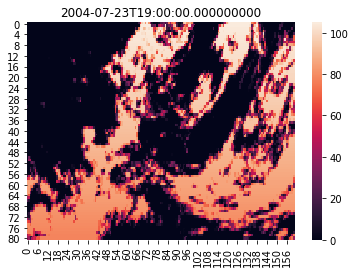

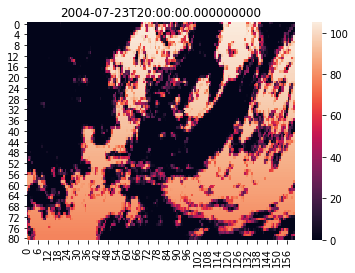

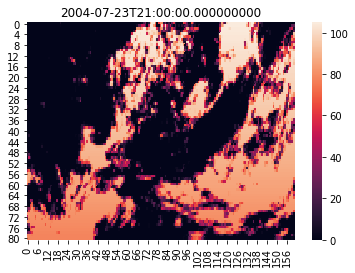

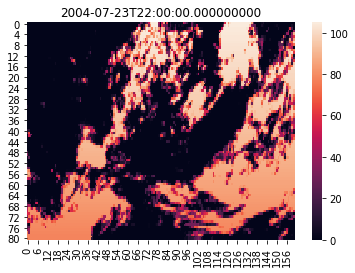

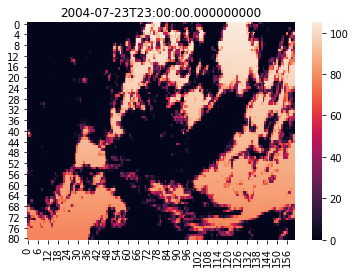

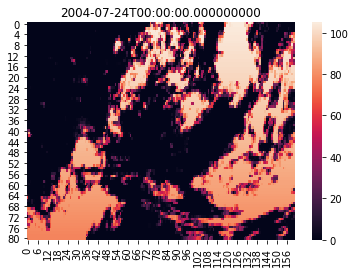

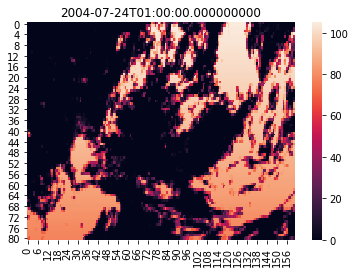

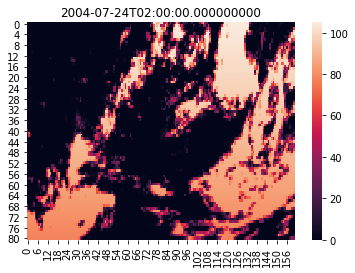

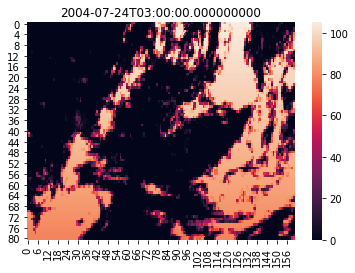

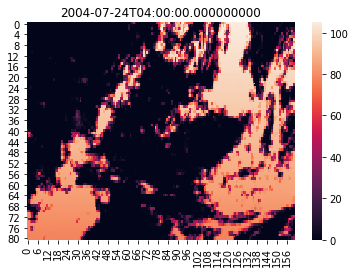

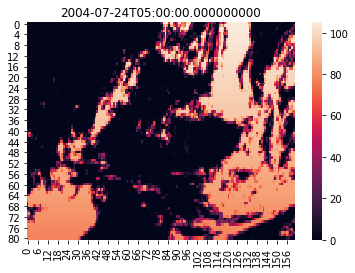

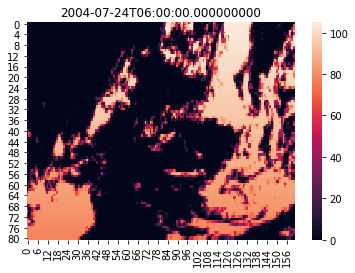

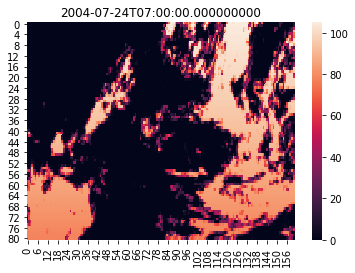

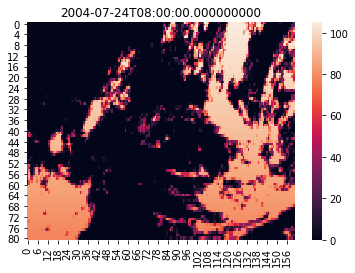

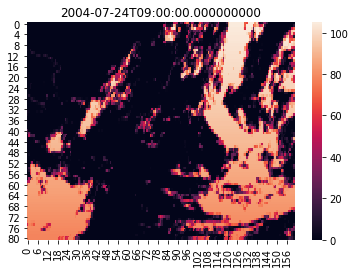

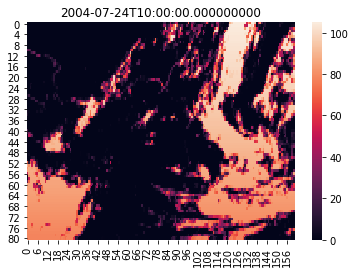

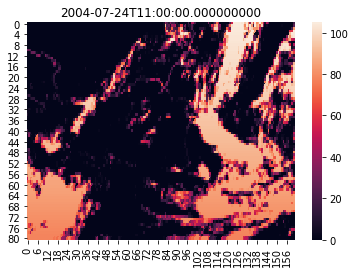

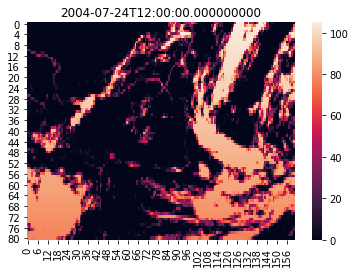

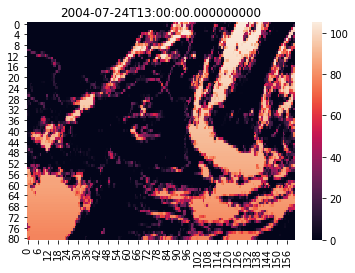

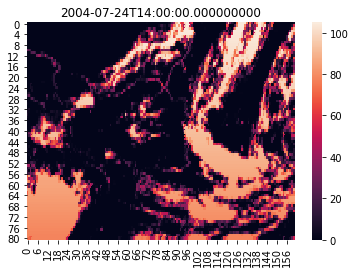

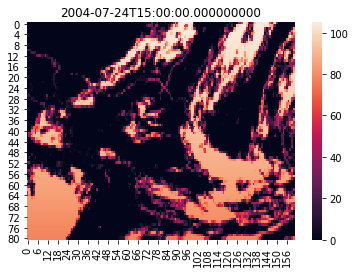

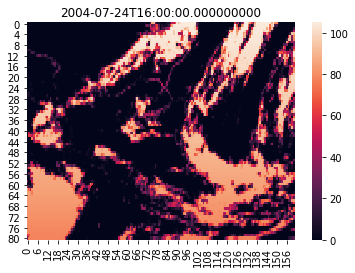

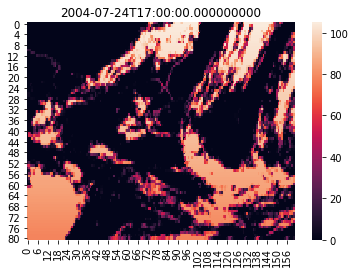

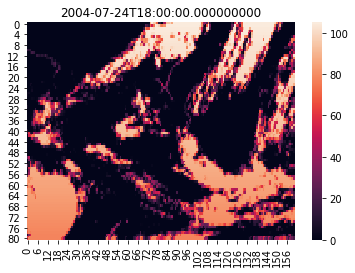

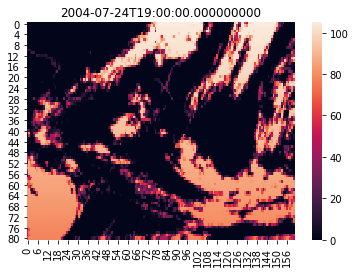

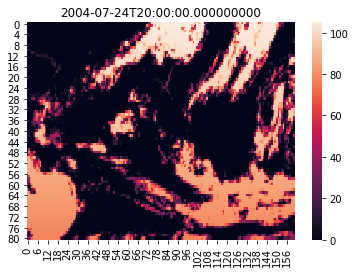

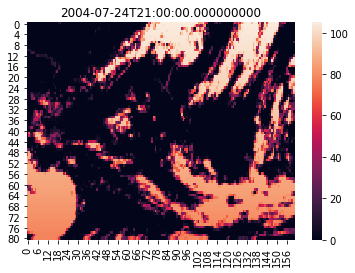

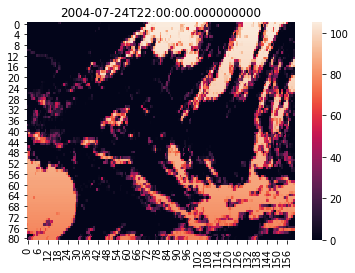

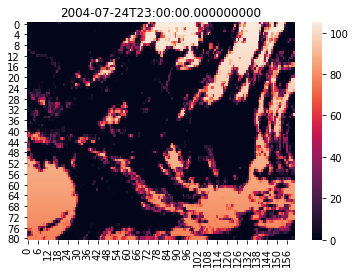

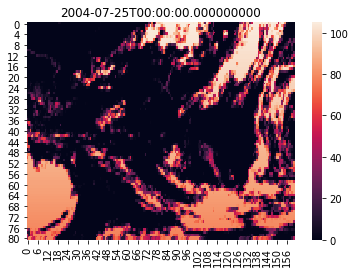

In [163]:
for t in ds.time.values:
    ax = sns.heatmap(ds.sel(time = t)['tcc'].values)
    ax.set_title(t)
    plt.savefig('/home/hanna/{}.png'.format(t))
    plt.show()

In [159]:
ds.sel(time = '2004-07-23T19:00:00')['tcc'].values

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 7.50374950e-02, 4.32332203e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 2.14756955e+01, 0.00000000e+00],
       ...,
       [7.87746404e+01, 7.87746404e+01, 7.87746404e+01, ...,
        0.00000000e+00, 0.00000000e+00, 1.30086386e+01],
       [4.31722508e+01, 5.81362950e+01, 6.35560657e+01, ...,
        3.11111383e-01, 4.16797030e+01, 7.53676065e+01],
       [4.19087782e+01, 4.00680702e+01, 1.37603641e+01, ...,
        6.49769578e+01, 7.52169555e+01, 3.91130892e+01]])

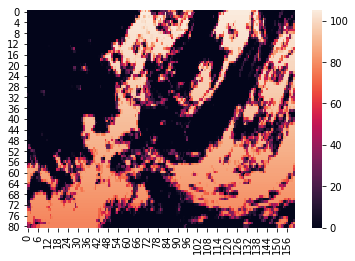

In [160]:
sns.heatmap(ds.sel(time = '2004-07-23T19:00:00')['tcc'].values)

# Write file and generate filename.

In [ ]:
def output_filename(var, start, stop, add_text_begin = ""):
    """
    Add test train or valid in front when this is appropriate.

    OBS: Var should be in terms of variables in the era-interim datasets.
    """
    return (save_dir + add_text_begin + var + "_" + start + "_" +
                stop + "_" + season_str + ".nc")
